In [1]:
import os
import numpy as np
import importlib

import torch
from torch.utils.data import DataLoader

from utils.common import plot_hist_seaborn, plot_ROC_curve, read_annotations, load_config
from utils.evaluation import evaluate_multiclass, metric_ood, compute_oscr
from data.dataset import ImageDataset
from models.models import Simple_CNN

In [2]:
import sys
sys.path

['/home/lihao/miniconda3/envs/pose_test/lib/python39.zip',
 '/home/lihao/miniconda3/envs/pose_test/lib/python3.9',
 '/home/lihao/miniconda3/envs/pose_test/lib/python3.9/lib-dynload',
 '',
 '/home/lihao/.local/lib/python3.9/site-packages',
 '/home/lihao/miniconda3/envs/pose_test/lib/python3.9/site-packages',
 '/home/lihao/miniconda3/envs/pose_test/lib/python3.9/site-packages/setuptools/_vendor']

In [3]:
def get_feature(model, dataloader, config, device):
    model.eval()
    Loss = importlib.import_module('loss.' + config.loss)
    criterion = getattr(Loss, config.loss)(config).to(device)
    with torch.no_grad():
        features = []
        labels =[]
        probs=[]
        for i, batch in enumerate(dataloader):
            input_img_batch, label_batch, _ = batch 
            input_img = input_img_batch.reshape((-1, 3, input_img_batch.size(-2), input_img_batch.size(-1))).to(device)
            label = label_batch.reshape((-1)).to(device)
            prob, feature = model(input_img, data='dct')
            prob, _ = criterion(feature, prob)

            if i == 0:
                probs = prob
                gt_labels = label
                features = feature
            else:
                probs = torch.cat([probs, prob], dim=0)
                gt_labels = torch.cat([gt_labels, label])
                features=torch.cat(([features, feature]))

    features = features.cpu().numpy()
    probs = probs.cpu().numpy()
    labels = gt_labels.cpu().numpy()
        
    return features, labels, probs

In [4]:
def calculate_open_set_result(_labels_k, _labels_u, _pred_k, _pred_u, known_feature, unknown_feature, known_classes, unknown_classes, save_dir):
    
    x1, x2 = np.max(_pred_k, axis=1), np.max(_pred_u, axis=1)
    out_results = metric_ood(x1, x2)['Bas'] # check
    _oscr_socre = compute_oscr(_pred_k, _pred_u, _labels_k)
    unknown_perf = round(out_results['AUROC'], 2)

    print("AUC, OSCR : {:.2f} {:.2f}".format(unknown_perf, _oscr_socre*100))

    # plot confidence histogram and ROC curve
    os.makedirs(save_dir, exist_ok=True)
    plot_hist_seaborn(x1, x2, save_path = os.path.join(save_dir,'hist.png'))
    plot_ROC_curve(out_results, save_path = os.path.join(save_dir,'roc.png'))
    
    # print detailed results for each unknown class
    for i, label_u in enumerate(set(_labels_u)):
        pred_u = _pred_u[_labels_u==label_u]
        x1, x2 = np.max(_pred_k, axis=1), np.max(pred_u, axis=1)
        pred = np.argmax(pred_u, axis=1)
        pred_labels = list(set(pred))
        pred_nums = [np.sum(pred==p) for p in pred_labels]
        result = metric_ood(x1, x2, verbose=False)['Bas']
        print("{}\t \t mostly pred class: {}\t \t average score: {}\t AUROC (%): {:.2f}".format(unknown_classes[i], 
                                                                                 known_classes[pred_labels[np.argmax(pred_nums)]],
                                                                                 np.mean(x2), result['AUROC']))

In [5]:
device = 'cuda:3'
config = load_config('configs.{}'.format('progressive'))

# load model
model_path = './checkpoints/split1/model.pth'
model = Simple_CNN(class_num=15, out_feature_result=True)
pretrained_dict = torch.load(model_path, map_location='cpu')['state_dict']
model.load_state_dict(pretrained_dict)
model = model.to(device)

In [6]:
test_data_path = '/home/lihao/python_proj/AIGC_2025/others_work/POSE/dataset/split1_test/annotations/split1_test.txt'
close_set = ImageDataset(read_annotations(test_data_path), config, balance=False, test_mode=True)
close_loader = DataLoader(
    dataset=close_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
known_feature, known_label, known_prob  = get_feature(model, close_loader, config, device)
pred_labels = np.argmax(known_prob, axis=1)
results = evaluate_multiclass(known_label, pred_labels)
print('closed-set accuracy', round(results['acc'], 4)*100)

/home/lihao/python_proj/AIGC_2025/others_work/POSE/loss/Softmax.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


closed-set accuracy 91.7


/home/lihao/python_proj/AIGC_2025/others_work/POSE/loss/Softmax.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas     6.400 68.297 66.750 80.635 49.056
AUC, OSCR : 68.30 65.64


/home/lihao/python_proj/AIGC_2025/others_work/POSE/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)
/home/lihao/python_proj/AIGC_2025/others_work/POSE/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)


celeba_ProGAN_seed1	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6568686366081238	 AUROC (%): 60.54
celeba_ProGAN_seed2	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6596274375915527	 AUROC (%): 60.00
celeba_ProGAN_seed3	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6672715544700623	 AUROC (%): 59.28
celeba_ProGAN_seed4	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6446784734725952	 AUROC (%): 62.29
celeba_ProGAN_seed5	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6413830518722534	 AUROC (%): 63.20
lsun_ProGAN_seed1	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 0.4800100028514862	 AUROC (%): 81.68
lsun_ProGAN_seed2	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 0.5866941213607788	 AUROC (%): 70.35
lsun_ProGAN_seed3	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 0.5192276835441589	 AUROC (%): 77.58
lsun_ProGAN_seed4	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 

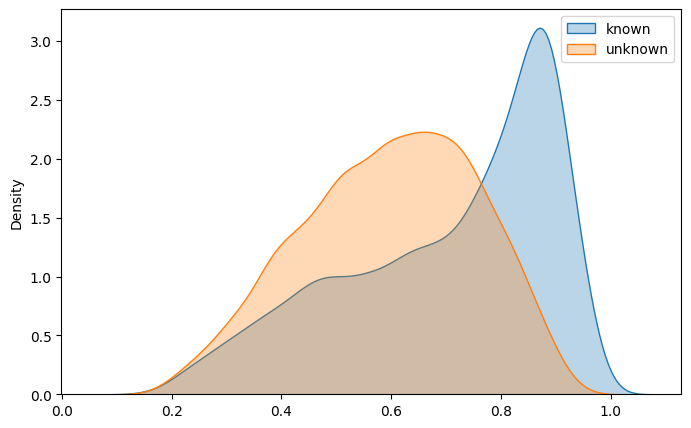

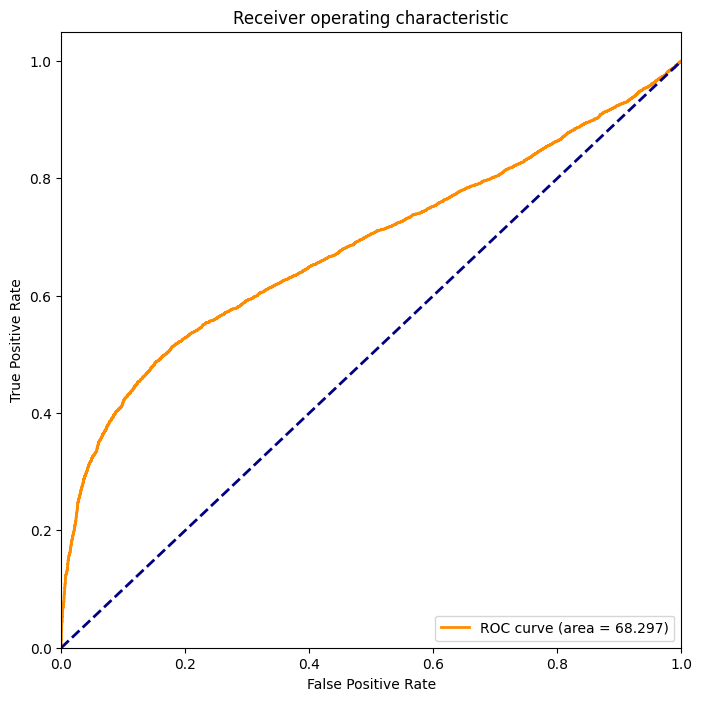

In [7]:
out_data_path = '/home/lihao/python_proj/AIGC_2025/others_work/POSE/dataset/split1_test/annotations/split1_test_out_seed.txt'
out_set = ImageDataset(read_annotations(out_data_path), config, balance=False, test_mode=True)
out_loader = DataLoader(
    dataset=out_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
out_feature, out_label, out_prob  = get_feature(model, out_loader, config, device)
known_classes = ['real', 'celeba_ProGAN_seed0', 'celeba_StarGAN', 'FFHQ_StyleGAN3_r', 'FFHQ_StyleGAN3_t', 'SNGAN_imagenet', 'SAGAN_imagenet', 'lsun_ProGAN_seed0', 'lsun_MMDGAN', 'FaceSwap', 'FSGAN', 'stylegan_cat', 'stylegan3_cat', 'stylegan_bus', 'progan_bus']
unknown_classes = ['celeba_ProGAN_seed1', 'celeba_ProGAN_seed2', 'celeba_ProGAN_seed3', 'celeba_ProGAN_seed4', 'celeba_ProGAN_seed5',\
                   'lsun_ProGAN_seed1', 'lsun_ProGAN_seed2', 'lsun_ProGAN_seed3', 'lsun_ProGAN_seed4', 'lsun_ProGAN_seed5']
calculate_open_set_result(known_label, out_label, known_prob, out_prob, known_feature, out_feature, known_classes, unknown_classes, './results/unseen_seed')


/home/lihao/python_proj/AIGC_2025/others_work/POSE/loss/Softmax.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    42.909 84.447 76.273 78.980 87.739
AUC, OSCR : 84.45 79.12


/home/lihao/python_proj/AIGC_2025/others_work/POSE/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)
/home/lihao/python_proj/AIGC_2025/others_work/POSE/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)


celeba_MMDGAN	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.28896376490592957	 AUROC (%): 96.22
celeba_AttGAN	 	 mostly pred class: lsun_MMDGAN	 	 average score: 0.25971314311027527	 AUROC (%): 97.45
celeba_SNGAN	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.5659055113792419	 AUROC (%): 72.10
celeba_InfomaxGAN	 	 mostly pred class: real	 	 average score: 0.271400511264801	 AUROC (%): 96.94
FFHQ_StyleGAN2	 	 mostly pred class: FFHQ_StyleGAN3_t	 	 average score: 0.5844159126281738	 AUROC (%): 71.79
CelebA_HQ_ProGAN	 	 mostly pred class: real	 	 average score: 0.47974249720573425	 AUROC (%): 81.96
CelebA_HQ_StyleGAN	 	 mostly pred class: real	 	 average score: 0.4914023280143738	 AUROC (%): 80.57
BigGAN_imagenet	 	 mostly pred class: real	 	 average score: 0.27250251173973083	 AUROC (%): 96.72
S3GAN_imagenet	 	 mostly pred class: lsun_MMDGAN	 	 average score: 0.2903364598751068	 AUROC (%): 95.14
ContraGAN_imagenet	 	 mostly pred class: real	 	 average score

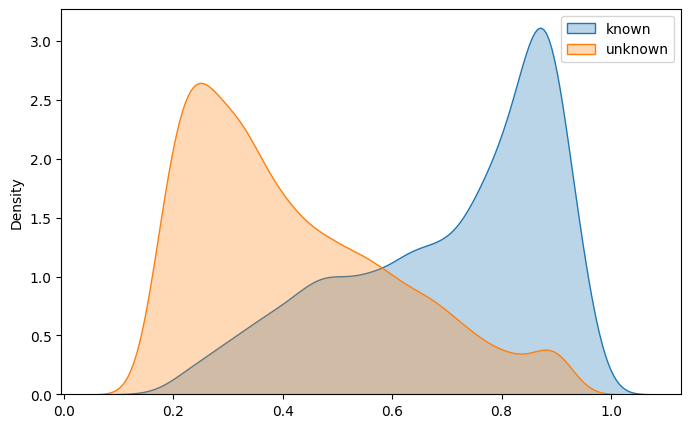

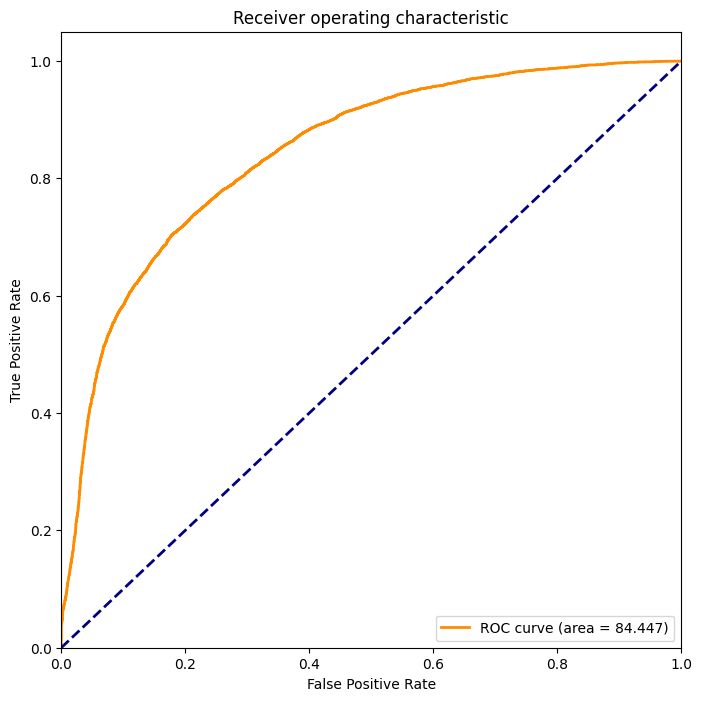

In [8]:
out_data_path = '/home/lihao/python_proj/AIGC_2025/others_work/POSE/dataset/split1_test/annotations/split1_test_out_arch.txt'
out_set = ImageDataset(read_annotations(out_data_path), config, balance=False, test_mode=True)
out_loader = DataLoader(
    dataset=out_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
out_feature, out_label, out_prob = get_feature(model, out_loader, config, device)
known_classes = ['real', 'celeba_ProGAN_seed0', 'celeba_StarGAN', 'FFHQ_StyleGAN3_r', 'FFHQ_StyleGAN3_t', 'SNGAN_imagenet', 'SAGAN_imagenet', 'lsun_ProGAN_seed0', 'lsun_MMDGAN', 'FaceSwap', 'FSGAN', 'stylegan_cat', 'stylegan3_cat', 'stylegan_bus', 'progan_bus']
unknown_classes = ['celeba_MMDGAN', 'celeba_AttGAN', 'celeba_SNGAN', 'celeba_InfomaxGAN', \
                   'FFHQ_StyleGAN2', 'CelebA_HQ_ProGAN', 'CelebA_HQ_StyleGAN', \
                   'BigGAN_imagenet', 'S3GAN_imagenet', 'ContraGAN_imagenet', \
                   'lsun_SNGAN', 'lsun_InfomaxGAN', \
                   'Faceshifter', 'wav2lip', \
                   'stylegan2_cat', 'progan_cat', 'mmdgan_cat', 'sngan_cat', \
                   'stylegan2_bus', 'stylegan3_bus', 'mmdgan_bus', 'sngan_bus']
calculate_open_set_result(known_label, out_label, known_prob, out_prob, known_feature, out_feature, known_classes, unknown_classes, './results/unseen_arch')

<Figure size 640x480 with 0 Axes>

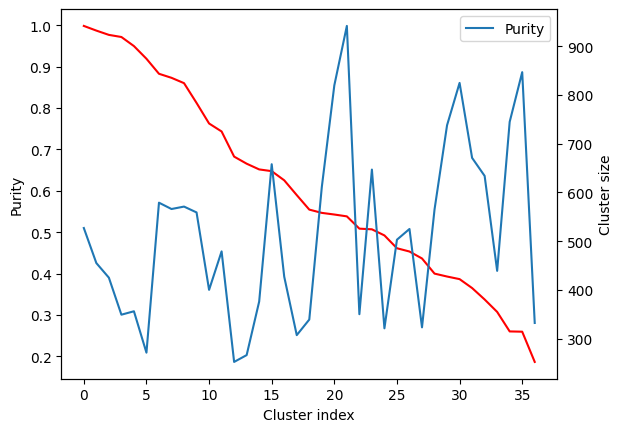

Data points 19000 Clusters 37
Average purity: 0.5815 NMI: 0.7179 ARI: 0.4655 
NMI: 0.72, cluster_acc: 0.58, purity: 0.47


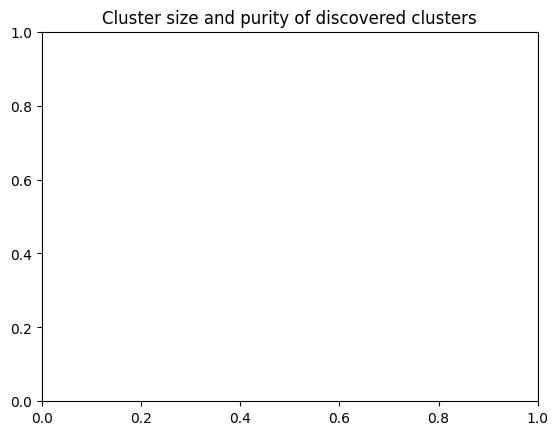

: 

In [9]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.metrics import accuracy_score, recall_score, f1_score
def metric_cluster(X_selected, n_clusters, y, cluster_method='kmeans',path='./cluster_res'):
    """
    This function calculates ARI, ACC and NMI of clustering results
    Input
    -----
    X_selected: {numpy array}, shape (n_samples, n_selected_features}
            input data on the selected features
    n_clusters: {int}
            number of clusters
    y: {numpy array}, shape (n_samples,)
            true labels
    Output
    ------
    nmi: {float}
        Normalized Mutual Information
    acc: {float}
        Accuracy
    """
    if cluster_method == 'kmeans':
        cluster_alg = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300,
                     tol=0.0001, precompute_distances=True, verbose=0,
                     random_state=None, copy_x=True, n_jobs=1)
    elif cluster_method == 'minibatch_kmeans':
        cluster_alg = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=2048)
    elif cluster_method == 'dbscan':
        cluster_alg = DBSCAN(eps=3, min_samples=2)
    else:
        raise ValueError('select kmeans or dbscan for cluster')

    cluster_alg.fit(X_selected)
    y_predict = cluster_alg.labels_

    # # from openworld-gan, same as above
    nmi, purity, ari = cluster_stats(y_predict, y, path)

    return nmi, purity, ari


def cluster_stats(predicted, targets, save_path=None):
    n_clusters = np.unique(predicted).size
    n_classes  = np.unique(targets).size
    num = np.zeros([n_clusters,n_classes])
    unique_targets = np.unique(targets)
    for i,p in enumerate(np.unique(predicted)):
        class_labels = targets[predicted==p]
        num[i,:] = np.sum(class_labels[:,np.newaxis]==unique_targets[np.newaxis,:],axis=0)
    sum_clusters = np.sum(num,axis=1)
    purity = np.max(num,axis=1)/(sum_clusters+(sum_clusters==0).astype(sum_clusters.dtype))
    indices = np.argsort(-purity)

    if save_path is not None:
        plt.clf()
        fig, ax1 = plt.subplots()
        ax1.plot(purity[indices],color='red')
        ax1.set_xlabel('Cluster index')
        ax1.set_ylabel('Purity')
        ax2 = ax1.twinx()
        ax2.plot(sum_clusters[indices])
        ax2.set_ylabel('Cluster size')
        plt.legend(('Purity','Cluster size'))
        plt.show()
        plt.title('Cluster size and purity of discovered clusters')
        plt.savefig(save_path)
    print('Data points {} Clusters {}'.format(np.sum(sum_clusters).astype(np.int64), n_clusters))
    print('Average purity: {:.4f} '.format(np.sum(purity*sum_clusters)/np.sum(sum_clusters))+\
          'NMI: {:.4f} '.format(normalized_mutual_info_score(targets, predicted))+\
          'ARI: {:.4f} '.format(adjusted_rand_score(targets, predicted)))
    avg_purity = np.sum(purity*sum_clusters)/np.sum(sum_clusters) 
    nmi = normalized_mutual_info_score(targets, predicted) 
    ari = adjusted_rand_score(targets, predicted) 
    return nmi, avg_purity, ari
features = np.concatenate([known_feature, out_feature])
labels = np.concatenate([known_label,  out_label+len(known_label)]) # 避免重复
class_num = len(set(known_label)) + len(set(out_label))
NMI, cluster_acc, purity = metric_cluster(features, class_num, labels, 'minibatch_kmeans')
print("NMI: {:.2f}, cluster_acc: {:.2f}, purity: {:.2f}".format(NMI, cluster_acc, purity))

/home/lihao/python_proj/AIGC_2025/others_work/POSE/loss/Softmax.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    39.419 86.800 79.246 85.303 87.174
AUC, OSCR : 86.80 81.31


/home/lihao/python_proj/AIGC_2025/others_work/POSE/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)
/home/lihao/python_proj/AIGC_2025/others_work/POSE/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)


stylegan_airplane	 	 mostly pred class: stylegan_bus	 	 average score: 0.35625916719436646	 AUROC (%): 90.15
stylegan_bridge	 	 mostly pred class: stylegan_bus	 	 average score: 0.4569073021411896	 AUROC (%): 82.68
stylegan_church_outdoor	 	 mostly pred class: real	 	 average score: 0.362641841173172	 AUROC (%): 91.56
stylegan_classroom	 	 mostly pred class: stylegan_bus	 	 average score: 0.34691035747528076	 AUROC (%): 92.75
stylegan_cow	 	 mostly pred class: stylegan_bus	 	 average score: 0.3095802366733551	 AUROC (%): 94.47
stylegan_kitchen	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 0.3674072027206421	 AUROC (%): 91.55
stylegan_sheep	 	 mostly pred class: stylegan_bus	 	 average score: 0.32698488235473633	 AUROC (%): 93.26
stylegan3_airplane	 	 mostly pred class: stylegan3_cat	 	 average score: 0.4082176387310028	 AUROC (%): 87.60
stylegan3_bridge	 	 mostly pred class: stylegan3_cat	 	 average score: 0.3873082101345062	 AUROC (%): 89.57
stylegan3_church_outdoor	 	 mos

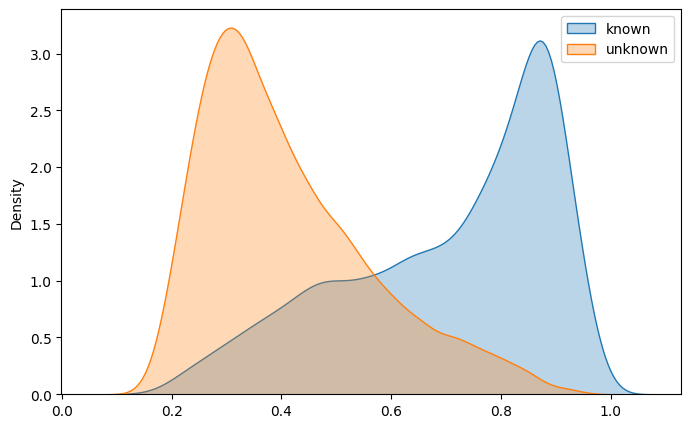

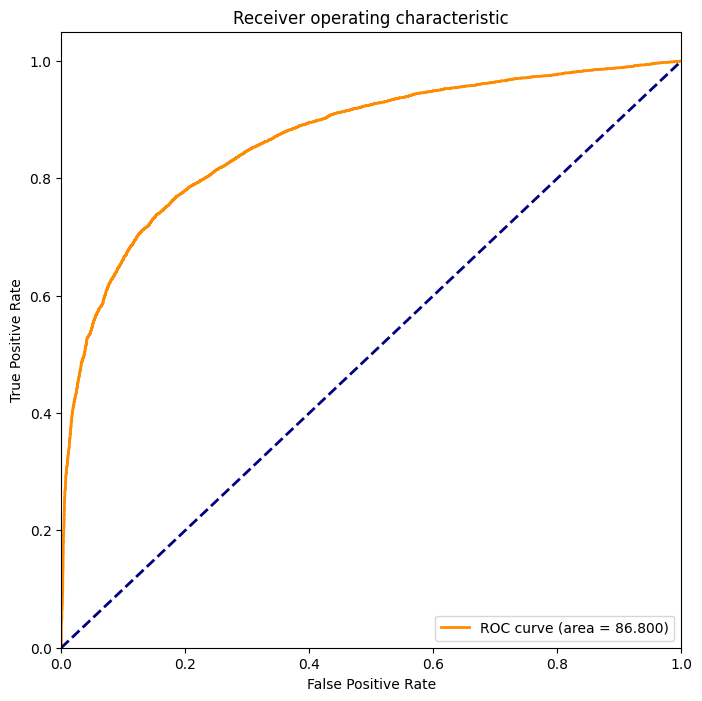

In [11]:
# result on unseen dataset 
out_data_path = '/home/lihao/python_proj/AIGC_2025/others_work/POSE/dataset/split1_test/annotations/split1_test_out_dataset.txt'
out_set = ImageDataset(read_annotations(out_data_path), config, balance=False, test_mode=True)
out_loader = DataLoader(
    dataset=out_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
out_feature, out_label, out_prob  = get_feature(model, out_loader, config, device)
known_classes = ['real', 'celeba_ProGAN_seed0', 'celeba_StarGAN', 'FFHQ_StyleGAN3_r', 'FFHQ_StyleGAN3_t', 'SNGAN_imagenet', 'SAGAN_imagenet', 'lsun_ProGAN_seed0', 'lsun_MMDGAN', 'FaceSwap', 'FSGAN', 'stylegan_cat', 'stylegan3_cat', 'stylegan_bus', 'progan_bus']
unknown_classes = ['stylegan_airplane', 'stylegan_bridge', 'stylegan_church_outdoor', 'stylegan_classroom', 'stylegan_cow', 'stylegan_kitchen', 'stylegan_sheep', \
                   'stylegan3_airplane', 'stylegan3_bridge', 'stylegan3_church_outdoor', 'stylegan3_classroom', 'stylegan3_cow', 'stylegan3_kitchen', 'stylegan3_sheep', \
                   'progan_airplane', 'progan_bridge', 'progan_church_outdoor', 'progan_classroom', 'progan_cow', 'progan_kitchen', 'progan_sheep']
calculate_open_set_result(known_label, out_label, known_prob, out_prob, known_feature, out_feature, known_classes, unknown_classes, './results/unseen_dataset')


In [4]:
import numpy as np
def get_curve_online(known, novel, stypes = ['Bas']):
    tp, fp = dict(), dict()
    tnr_at_tpr95 = dict()
    for stype in stypes:
        known.sort()
        novel.sort()
        end = np.max([np.max(known), np.max(novel)])
        start = np.min([np.min(known),np.min(novel)])
        num_k = known.shape[0]
        num_n = novel.shape[0]
        tp[stype] = -np.ones([num_k+num_n+1], dtype=int)
        fp[stype] = -np.ones([num_k+num_n+1], dtype=int)
        tp[stype][0], fp[stype][0] = num_k, num_n
        k, n = 0, 0
        for l in range(num_k+num_n):
            if k == num_k:
                tp[stype][l+1:] = tp[stype][l]
                fp[stype][l+1:] = np.arange(fp[stype][l]-1, -1, -1)
                break
            elif n == num_n:
                tp[stype][l+1:] = np.arange(tp[stype][l]-1, -1, -1)
                fp[stype][l+1:] = fp[stype][l]
                break
            else:
                if novel[n] < known[k]:
                    n += 1
                    tp[stype][l+1] = tp[stype][l]
                    fp[stype][l+1] = fp[stype][l] - 1
                else:
                    k += 1
                    tp[stype][l+1] = tp[stype][l] - 1
                    fp[stype][l+1] = fp[stype][l]
        tpr95_pos = np.abs(tp[stype] / num_k - .95).argmin()
        tnr_at_tpr95[stype] = 1. - fp[stype][tpr95_pos] / num_n
    return tp, fp, tnr_at_tpr95

known = np.asarray([0.7, 0.8, 0.9])
novel = np.asarray([0.1, 0.3, 0.6])
get_curve_online(known,novel)

({'Bas': array([3, 3, 3, 3, 2, 1, 0])},
 {'Bas': array([3, 2, 1, 0, 0, 0, 0])},
 {'Bas': 0.0})